In [1]:
from EVFleet import * 
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, time
import numpy as np
import cvxpy as cp

In [3]:
def create_energy_set(start, M, H, pv, wt):
    days = 365 // M -1
    q = np.zeros((M, H))
    Q = np.zeros((M, days * 24))
    for m in range(M):
        start_idx = m * days * 24
        end_idx = (m + 1) * days * 24
        Q[m, :] = pv[start_idx:end_idx] + wt[start_idx:end_idx]
        q[m, :] = Q[m, start:start+H]

    return q

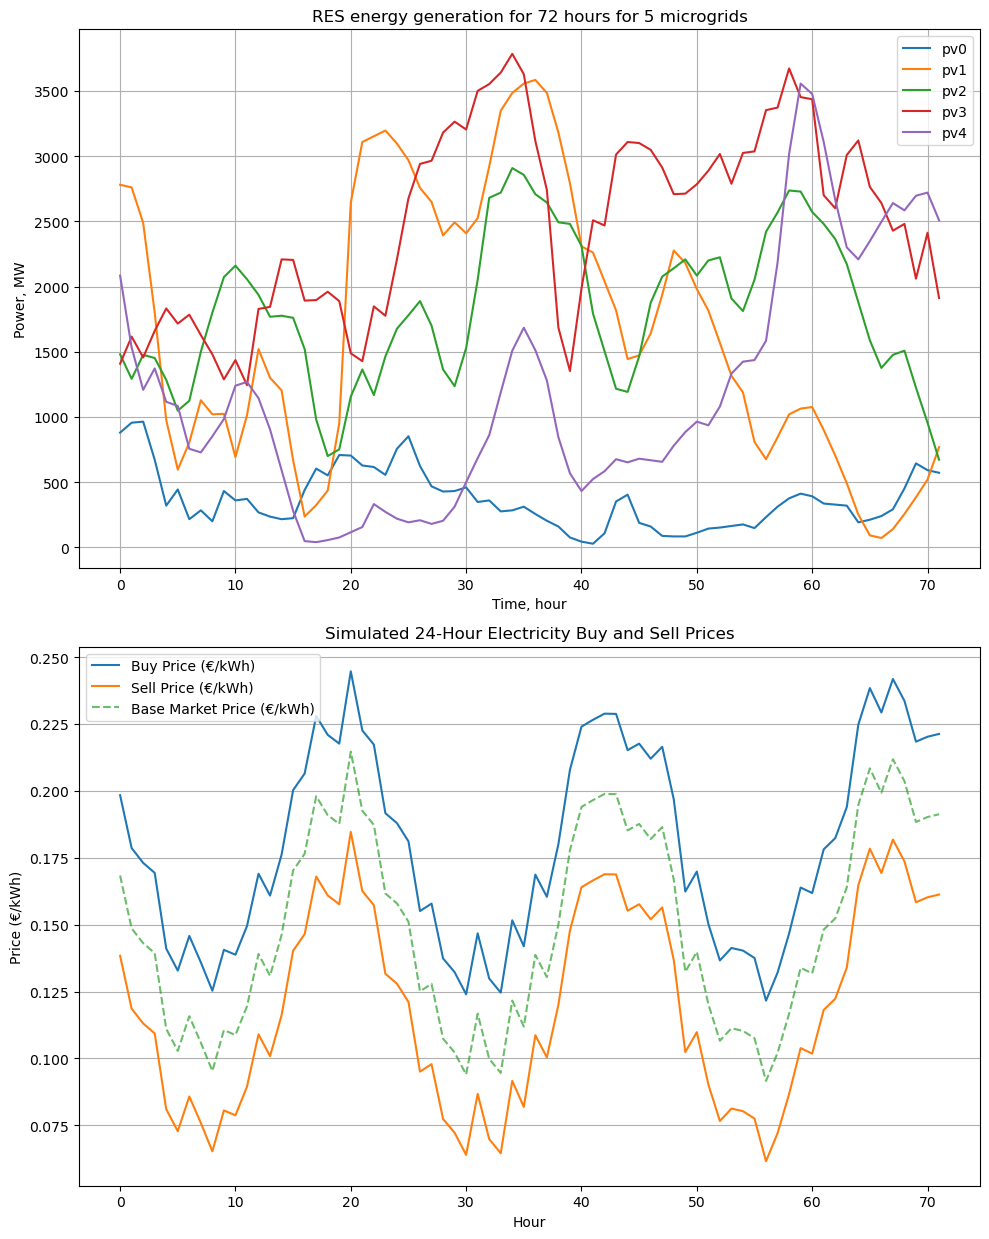

In [5]:
DAYS = 3
H=24
N=5
M=5
start = 0

# Set seed for reproducibility
np.random.seed(42)

hours = np.arange(24*DAYS)
base_price = 0.15
amplitude = 0.10

noise = np.random.normal(0, 0.01, size=24*DAYS)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.03
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()


q = create_energy_set(start, M, H*DAYS, pv_arr, wt_arr)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

axs[0].set_title(f'RES energy generation for {H*DAYS} hours for {M} microgrids')
for m in range(M): 
    axs[0].plot(np.arange(start, start+H*DAYS), q[m,:], label=f"pv{m}")
axs[0].legend()
axs[0].set_xlabel('Time, hour')
axs[0].set_ylabel('Power, MW')
axs[0].grid(True)
# First subplot: Buy and Sell Prices
axs[1].plot(hours, c, label='Buy Price (€/kWh)')
axs[1].plot(hours, p, label='Sell Price (€/kWh)')
axs[1].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[1].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Price (€/kWh)")
axs[1].grid(axis='y')
axs[1].legend()

plt.tight_layout()
plt.savefig("MPC environmental parameters", dpi=300)
plt.show()

In [24]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=25)
results = fleet.simulate_multiple_days(num_days=2)

L_usage = np.zeros((M,N,DAYS,4))
for row in results:
    print(row)
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 0] = int(row['Initial SoC'])
    print(L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 0])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 1] = int(row['Goal (kWh)'])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 2] = int(row['Arrival (h)'])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 3] = int(row['Departure (h)'])
    #print(L_usage[row['EV'] // 5, row['EV'] % 5, row['Day'], :])
    

{'Initial SoC': 1578.09, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 0, 'Day': 1}
1578.0
{'Initial SoC': 1760.78, 'Goal (kWh)': 8000.0, 'Arrival (h)': 17.25, 'Departure (h)': 7.5, 'EV': 1, 'Day': 1}
1760.0
{'Initial SoC': 1748.04, 'Goal (kWh)': 4000.0, 'Arrival (h)': 10.5, 'Departure (h)': 9.0, 'EV': 2, 'Day': 1}
1748.0
{'Initial SoC': 1035.99, 'Goal (kWh)': 4000.0, 'Arrival (h)': 10.5, 'Departure (h)': 9.0, 'EV': 3, 'Day': 1}
1035.0
{'Initial SoC': 1719.65, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 4, 'Day': 1}
1719.0
{'Initial SoC': 1036.9, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 5, 'Day': 1}
1036.0
{'Initial SoC': 1639.95, 'Goal (kWh)': 8000.0, 'Arrival (h)': 17.25, 'Departure (h)': 7.5, 'EV': 6, 'Day': 1}
1639.0
{'Initial SoC': 1219.31, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 7, 'Day': 1}
1219.0
{'Initial SoC': 1001.37, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25

In [112]:
class High_level_agent:
    def __init__(self, d_min=0, d_max=100, f_min=0, f_max=100, H=24):
        
        self.d_min = np.full(H, d_min)
        self.d_max = np.full(H, d_max)
        
        self.f_min = np.full(H, f_min)
        self.f_max = np.full(H, f_max)

        self.H = H
    
    def step(self, L_init, L_target, c, p, q):
        # Parameters
        c1 = 5
        c2 = 1
        np.random.seed(42)
        constraints = []
        objective = 0

        d = cp.Variable(H)
        f = cp.Variable(H)

        constraints += [
            d >= self.d_min,
            d <= self.d_max,
            f >= self.f_min,
            f <= self.f_max
        ]

        for h in range(1, self.H):
            constraints += [
                cp.abs(f[h-1] - f[h]) <= 100,
                cp.abs(d[h-1] - d[h]) <= 100
            ]

        energy_cost = cp.sum(cp.multiply(c, d) / q - cp.multiply(p, f) / q)
        expected_load = cp.sum(L_target - L_init)
        remaining_energy = cp.sum(q + d - f)
        energy_target =  cp.sum_squares(expected_load - remaining_energy)
        objective = c1 * energy_cost + c2 *energy_target
        # Solve the problem
        prob = cp.Problem(cp.Minimize(objective), constraints)
        prob.solve(solver="CLARABEL")
        # Collect data for plotting
        return d.value[0], f.value[0]

In [ ]:
class Low_level_agent:
    def __init__(self,L_min=1000, L_max=10000, l_min=0, l_max=1000, r_min=0, r_max=1000, H=24):
        # Parameters
        self.L_min = np.full((N,H), L_min)
        self.L_max = np.full((N,H), L_max)
        
        self.l_min = np.full((N,H), l_min)
        self.l_max = np.full((N,H), l_max)
        
        self.r_min = np.full((N,H), r_min)
        self.r_max = np.full((N,H), r_max)

        self.H = H
        
    def step(self, q, d_history, f_history, L_init, L_start, L_target, ):

        energy_terms = []
        penalty_terms = []
        
        # Initial values
        lambdas = np.zeros((H))
        x = np.array([np.zeros(3*H) for _ in range(N)])  # d, f, l, m, L[1:]

        x_prev = copy.deepcopy(x)
        iteration = 0
        
        E = q + d_history - f_history
        
        
        # Collect data for plotting
        l_history = np.array([np.zeros(H) for n in range(N)])
        r_history = np.array([np.zeros(H) for n in range(N)])
        L_history = np.array([np.zeros(H) for n in range(N)])
        
        H_n_T_x = np.zeros((N,H))
        H_n_T_xi = np.zeros((N,H))
        
        while True:
            iteration+=1
            #if iteration % 50 == 0:
                #rho *= 0.9

            for n in range(N):
                constraints = []

                l = xi[:H]
                r = xi[H:2*H]
                L = xi[2*H:3*H]
                    
                constraints += [
                    L >= self.L_min[n],
                    L <= self.L_max[n],
                    l >= self.l_min[n],
                    l <= self.l_max[n],
                    r >= self.r_min[n],
                    r <= self.r_max[n]
                ]
                
                constraints += [
                    L[L_start[n]] == self.L_init[n]
                ]
                    
                for h in range(1, H):
                    constraints += [
                        L[h] == L[h-1] + l[h] - r[h]
                        #cp.abs(l[h-1] - l[h]) <= 1,
                        #cp.abs(r[h-1] - r[h]) <= 1
                    ]
                    
                penalty_term = cp.sum_squares(L[-1]-L_target[m][n])
                h_n_T_x = l - r
                H_n_T_prev = cp.sum(H_n_T_x[m],axis=0) - H_n_T_x[m][n] - E[m]
                admm_penalty = (rho/2) * cp.sum_squares(h_n_T_x  + H_n_T_prev - 1/rho * lambdas[m])
                admm_update = (9/2) * cp.sum_squares(xi - x_prev[m][n])
            
                objective = cp.Minimize(penalty_term + admm_penalty + admm_update)
                prob = cp.Problem(objective, constraints)
                prob.solve(solver="CLARABEL")
            
                # Save values
                x[m][n] = copy.deepcopy(xi.value)
                H_n_T_xi[m][n] = copy.deepcopy(h_n_T_x.value)
            
                    # Collect data for plotting
                    l_history[m][n] = copy.deepcopy(l.value)
                    r_history[m][n] = copy.deepcopy(r.value)
                    L_history[m][n] = copy.deepcopy(L.value)
                    g = min(penalty_term.value, admm_penalty.value, admm_update.value)
        
                    #print(f"Penalty:{penalty_term.value//g}, Admm :{admm_penalty.value//g}, update:{admm_update.value//g}")
                    """
                    print(f"######### Parameters for Agent: {n} ##########")
                    print(f"Net cost: {penalty_term.value}")
                    print(f"Lambda penalty: {admm_penalty.value}")
                    print(f"Update penalty: {admm_update.value}")
                    #print(f"Objective value: {objective.value}")
                    print(f"############################################")
                    print(f" ")
                    #"""
            
            H_n_T_x = copy.deepcopy(H_n_T_xi)
            
            lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=1) - E)
            #gamma *=0.9
            print("--------------------------------------------")
            print(f"ITERATION: {iteration}, difference: {np.linalg.norm(x-x_prev)}")
            
            print(f"lambda {np.linalg.norm(np.sum(H_n_T_x,axis=1) - E)}")
            print("--------------------------------------------")
            print(f" ")
        
            if np.linalg.norm(x-x_prev) <= epsilon and np.linalg.norm(np.sum(H_n_T_x,axis=1) - E) < 0.8:
                    break
                
            lambda_history.append(np.linalg.norm(np.sum(H_n_T_x,axis=1) - E))  
            x_diff_histrory.append(np.linalg.norm(x-x_prev))
            x_prev = copy.deepcopy(x)

In [130]:
high_level_agents = [High_level_agent(d_min=0, d_max=1000, f_min=0, f_max=1000, H=24) for m in range(M)]

a = 0
simulation_time = H

d_history = np.zeros((M,H))
f_history = np.zeros((M,H))

for start in range(simulation_time):
    day = start // 24

    for m in range(M):
        d_history[m,start], f_history[m,start] = high_level_agents[m].step(L_init=L_usage[m,:,day,0], 
                                                                           L_target=L_usage[m,:,day,1], 
                                                                           c=c[start:start+H], 
                                                                           p=p[start:start+H], 
                                                                           q=q[m,start:start+H])


999.9999998833856
999.9999998705376
9.267395073721489e-08
2.4322612804158668e-08
999.9999999207091
999.9999999828265
963.2142521824509
3.86846994990354e-06
1.2169515976534263e-07
999.9999999979111
999.9999996763785
855.3999285458809
61.74997244061197
1.0294712287914061e-07
999.9999999848777
999.9999605034909
200.00000018670156
1.0521203015915582e-06
3.9311567838152053e-07
999.9999999883869
714.7367769680102
6.735712622825714e-06
94.923058324212
2.6600867766016293e-06
999.9999999702633
535.9993516041322
4.684485641907511e-08
200.00000856056695
7.013891084222722e-07
999.9999999837446
1.7584313536827775e-06
4.7462696374038113e-07
451.4545248287002
5.835329738551671e-07
999.999999959386
1.3782975702962148e-05
1.5995471350865414e-06
736.199990681447
1.1552244297731647e-07
999.9999999950821
3.04311491243757e-07
1.0376730378379e-06
801.1110782296424
1.3135399310417789e-08
999.9999999722147
299.9999997937337
1.1990712878463587e-07
675.7142362564373
2.750083773128199e-09
999.9999999937337
199.9

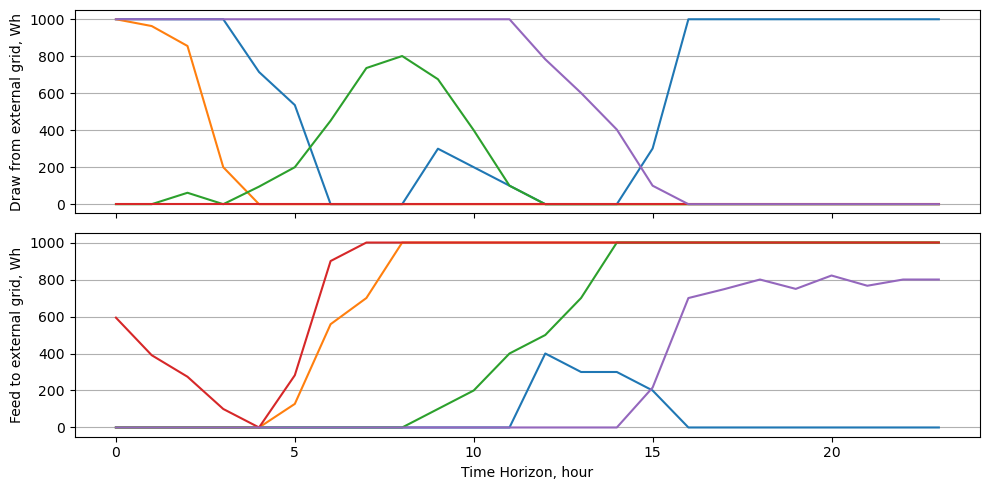

In [132]:

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 2*2.5), sharex=True)
    
for m in range(M):
    axes[0].plot(d_history[m])
    axes[0].grid(axis='y')
    axes[0].set_ylabel("Draw from external grid, Wh")
    axes[1].plot(f_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Feed to external grid, Wh")
    
axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.show()
